## Metodología

Para la resolución del reto, se utilizó un enfoque de aprendizaje profundo científico (Scientific Machine Learning) aplicado a un modelo determinista de crecimiento e interacción celular.
Este modelo es el sistema biológico se describe mediante un par de ecuaciones diferenciales ordinarias lineales de primer orden. Representa una relación de competencia o parasitismo donde la población tumoral se beneficia de la presencia de la población normal (o recursos), mientras que esta última se ve perjudicada.

$\dot T(t) = aT(t) + bN(t)$

$\dot N(t) = -cT(t)-dN(t)$

$\forall \;a,b,c,d,t,T_0,N_0 \in \mathbb{R} | a,b,c,d,t,T_0,N_0 > 0$

#### Implementación de la PINN
La estrategia para encontrar los parámetros y la solución del sistema consistió en:
1. Red Neuronal Aproximadora: Se construyó una red neuronal profunda $NN(t;\Theta)$que toma el tiempo t como entrada y produce dos salidas: $[T(t),N(t)]$.
2. Función de Pérdida (Physics Loss): La red se optimizará minimizando el residuo de las ecuaciones diferenciales. Gracias a la diferenciación automática de PyTorch, calculamos las derivadas $\frac{dT}{dt}$ y $\frac{dN}{dt}$ y formamos la siguiente función de costo:

$Loss=Loss(Datos)+LossEDO$

3. Restricción de Parámetros: Dado que el modelo exige que a, b, c, d > 0, durante el entrenamiento se aplicó una transformación a las variables aprendibles para asegurar que los coeficientes estimados se mantuvieran positivos y biológicamente coherentes.

#### Gerenación de datos
Se seleccionó un subconjunto de puntos dispersos y se les añadió ruido aleatorio para simular la recolección de datos experimentales, creando así el set de entrenamiento para la PINN.

#### Resolución del sistema usando la PINN
La red toma como entrada el tiempo $t$ y produce como salida las funciones aproximadas $\dot T(t)$ y $\dot N(t)$ .

Arquitectura utilizada:
- Entrada: tiempo $t$.
- Tres capas ocultas.
- Treinta y dos neuronas por capa.
- Función de activación tanh.
- Dos salidas: $T(t)$ y $N(t)$.

Los parámetros a, b, c y d se declararon como parámetros entrenables y se transformaron mediante funciones exponenciales para garantizar que permanezcan positivos.

Funcion de perdida
$L = MSE(T′(t) − (aT + bN))+ MSE(N′(t) − (−cT − dN)) + MSE(datos sintéticos) + MSE(condiciones iniciales)$

Donde las derivadas se obtienen con autograd de pytorch.
Para el entrenamiento se usaron 200 puntos en el intervalo $t \in [0,5]$ los datos fueron generados por RK4 y  finalmente ruido gaussiano del 2% para simular variación experimental.

En el entrenamiento se usó un optimizador de tipo Adam, y una tasa de aprendizaje de 0.001 divida en 12,000 épocas de entrenamiento y finalmente tenemos un ajuste mediante el optimizador LBFGS para mejorar la convergencia.

Resultados de la PINN:
- La PINN logró aproximar correctamente las trayectorias del sistema.
- Los parámetros estimados convergen a valores muy cercanos a los parámetros reales.
- El error relativo de la solución fue menor al 1.5 por ciento.

#### Implementación de los métodos numéricos
Como parte del estudio comparativo, se implementaron dos métodos numéricos tradicionales para resolver el sistema de ecuaciones diferenciales ordinarias: el método de Euler (conocido como RK1) y el método de Runge–Kutta de orden cuatro (RK4). Ambos métodos permiten obtener soluciones aproximadas del sistema y sirven como referencia para evaluar el desempeño de la PINN.

El método de Euler se implementó debido a su simplicidad y porque representa la aproximación numérica más básica para resolver EDOs. Aunque su precisión es limitada, su inclusión permite analizar cómo se comporta el sistema bajo un método explícito de primer orden y comparar su error con métodos más avanzados.

Por otro lado, el método de Runge–Kutta 4 se seleccionó por ser uno de los métodos numéricos más estables y precisos para resolver EDOs. Su orden superior permite obtener una solución muy cercana a la solución exacta del sistema, y se utilizó como “ground truth” para comparar tanto la solución obtenida mediante Euler como la solución producida por la PINN.

Ambos métodos se implementaron en Python. Para Euler se utilizó la fórmula iterativa básica, donde el valor siguiente depende del valor actual más el producto entre el paso de tiempo y la derivada en ese punto. Para RK4 se implementaron las cuatro etapas del método, calculando los coeficientes k1, k2, k3 y k4 para cada una de las variables, con el fin de obtener una aproximación más precisa en cada paso.


Resultados de los métodos numéricos tradicionales:

Se observó que ambos métodos generan curvas con un comportamiento prácticamente idéntico en el intervalo analizado. Dado que el sistema presenta una dinámica suave y sin cambios bruscos, incluso el método de Euler, a pesar de su simplicidad, logra aproximarse de manera adecuada a la solución. Por su parte, RK4 mantiene su característica precisión y estabilidad, pero en este caso la diferencia entre ambos métodos es mínima debido a la naturaleza lineal del sistema.

## Gráfica obtenida comparando los métodos empleados
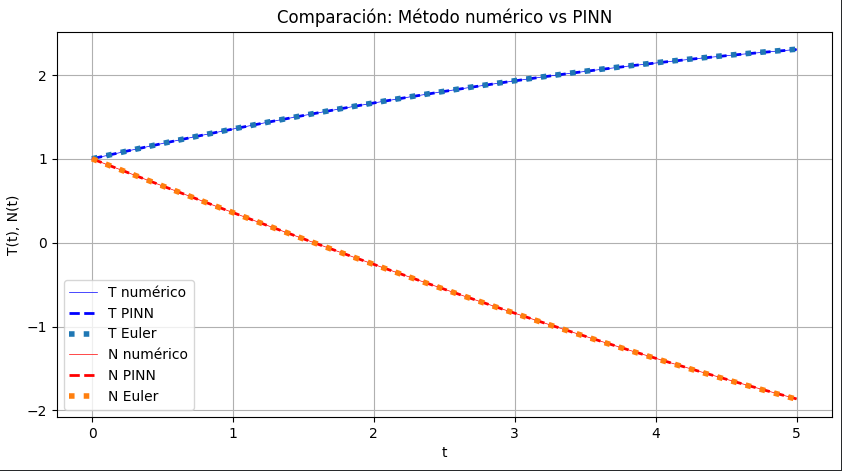

## Discución de resultados

A partir de la gráfica obtenida, se observa que las soluciones calculadas mediante la PINN, Euler y RK4 presentan una coincidencia casi perfecta a lo largo de todo el intervalo de estudio t [0,5]. Se podría llegar a decir que las curvas generadas por los métodos se superponen, lo que indica que la PINN fue capaz de aprender de manera adecuada la dinámica subyacente del sistema de ecuaciones diferenciales.
En el caso de la población tumoral T(t), ambas metodologías predicen un crecimiento progresivo conforme avanza el tiempo. Por otro lado, para la concentración de nutrientes 
N(t), tanto la PINN como el método RK4 muestran un decrecimiento continuo, lo cual coincide con la interpretación biológica del modelo: el tumor consume gradualmente los nutrientes disponibles, disminuyendo su concentración.
La pequeña (o nula) diferencia visible entre las trayectorias calculadas evidencia que el error relativo de la PINN es mínimo cuando se compara con un método clásico altamente preciso como RK4. Hasta lo mismo puede ser dicho comparándola con un método con menor precisión como lo es Euler. Esto valida la capacidad de las PINNs para resolver sistemas de ecuaciones diferenciales apoyándose en restricciones físicas, incluso en presencia de datos limitados o ruidosos.
